# Target image analysis

This notebook processes image data from the SNS target imaging system (TIS).

In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt
import proplot as pplt
import seaborn as sns
from scipy import ndimage

from target_image_analysis import Image
from target_image_analysis import read_files

sys.path.append('/Users/46h/Research/')
from accphys.tools import utils

In [2]:
plt.rcParams['grid.alpha'] = 0.05
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.facecolor'] = 'white'

In [5]:
utils.delete_files_not_folders('_output/')

## Load files

In [6]:
folder = '../_saved/2021-09-07/TBT_SCBD_0.5ms/target_image/data/'

In [7]:
images = read_files(utils.list_files(folder))

## Visualization 

In [8]:
n_turns_list = list(range(50, 550, 50))

In [9]:
def add_joint_grid(fig, gridspec, row, col):
    ax_joint = fig.add_subplot(gridspec[row, col])
    ax_marg_x = fig.add_subplot(gridspec[row - 1, col])
    ax_marg_y = fig.add_subplot(gridspec[row, col + 1])
    for ax in [ax_marg_x, ax_marg_y]:
        ax.set_xticks([])
        ax.set_yticks([])
        for side in ['top', 'bottom', 'left', 'right']:
            ax.spines[side].set_visible(False)
    for side in ['top', 'right']:
        ax_joint.spines[side].set_visible(False)
    return ax_joint, ax_marg_x, ax_marg_y

In [10]:
zoom = 1.2
sigma = 1.75 # for Gaussian filter

In [11]:
s = 1.0
max_hist2d_height = 0.
max_hist2d_height_filtered = 0.
max_hist_height_x = 0.
max_hist_height_y = 0.
for image in images:
    Z = image.Z
    Zf = image.filter(sigma)
    max_hist2d_height = max(np.max(Z), max_hist2d_height)
    max_hist2d_height_filtered = max(np.max(Zf), max_hist2d_height_filtered)
    max_hist_height_x = max(np.max(np.sum(Z, axis=0)), max_hist_height_x)
    max_hist_height_y = max(np.max(np.sum(Z, axis=1)), max_hist_height_y)
    
max_hist2d_height *= s
max_hist2d_height_filtered *= s

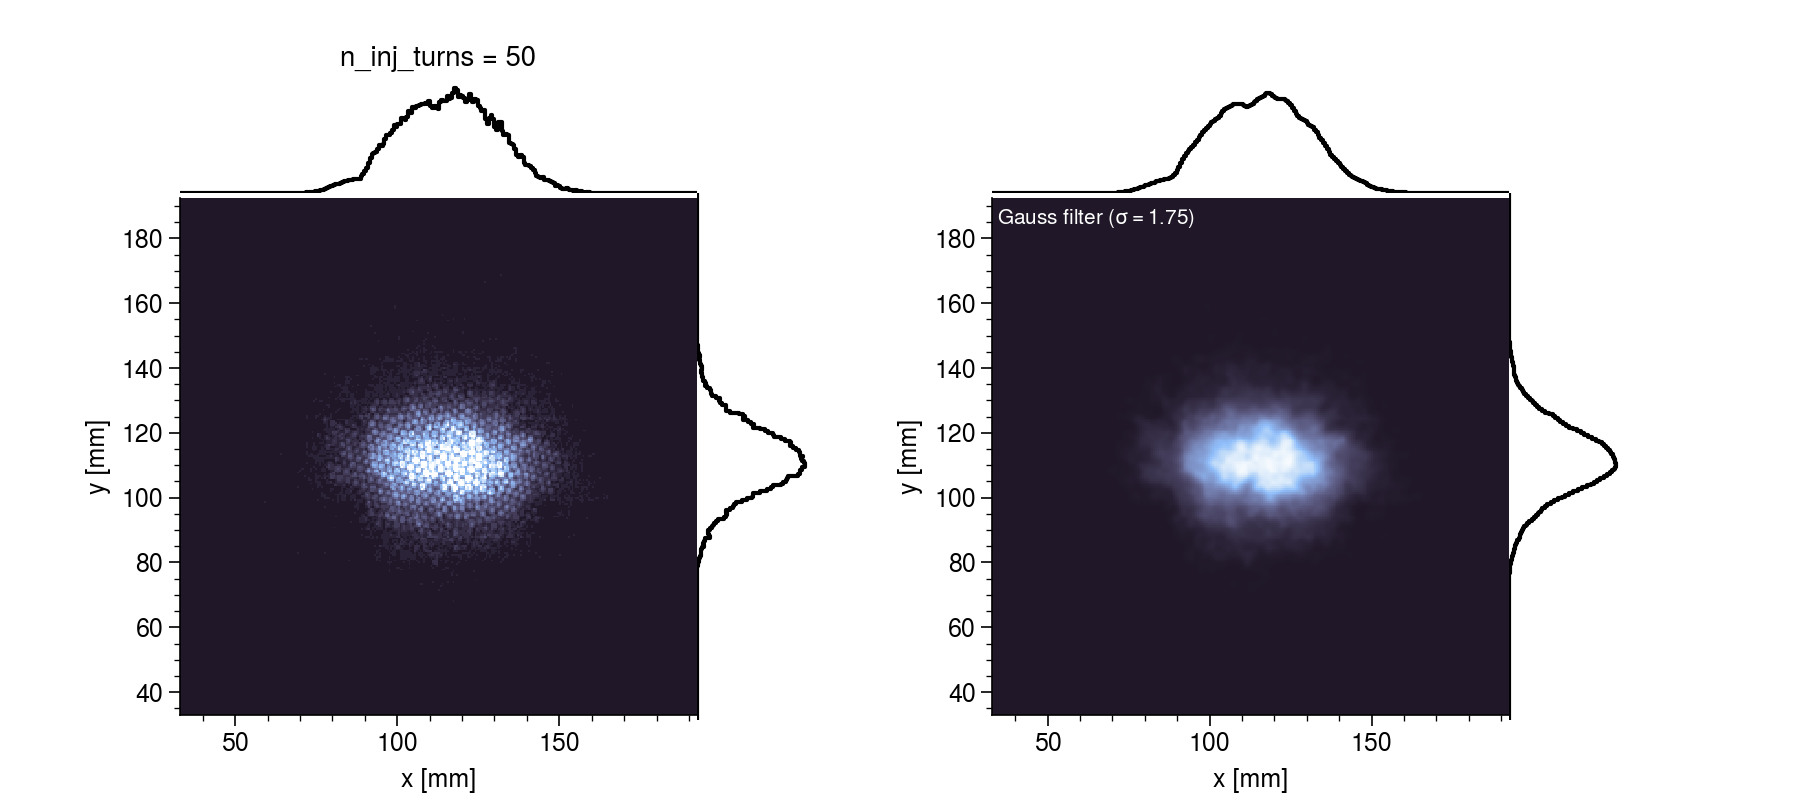

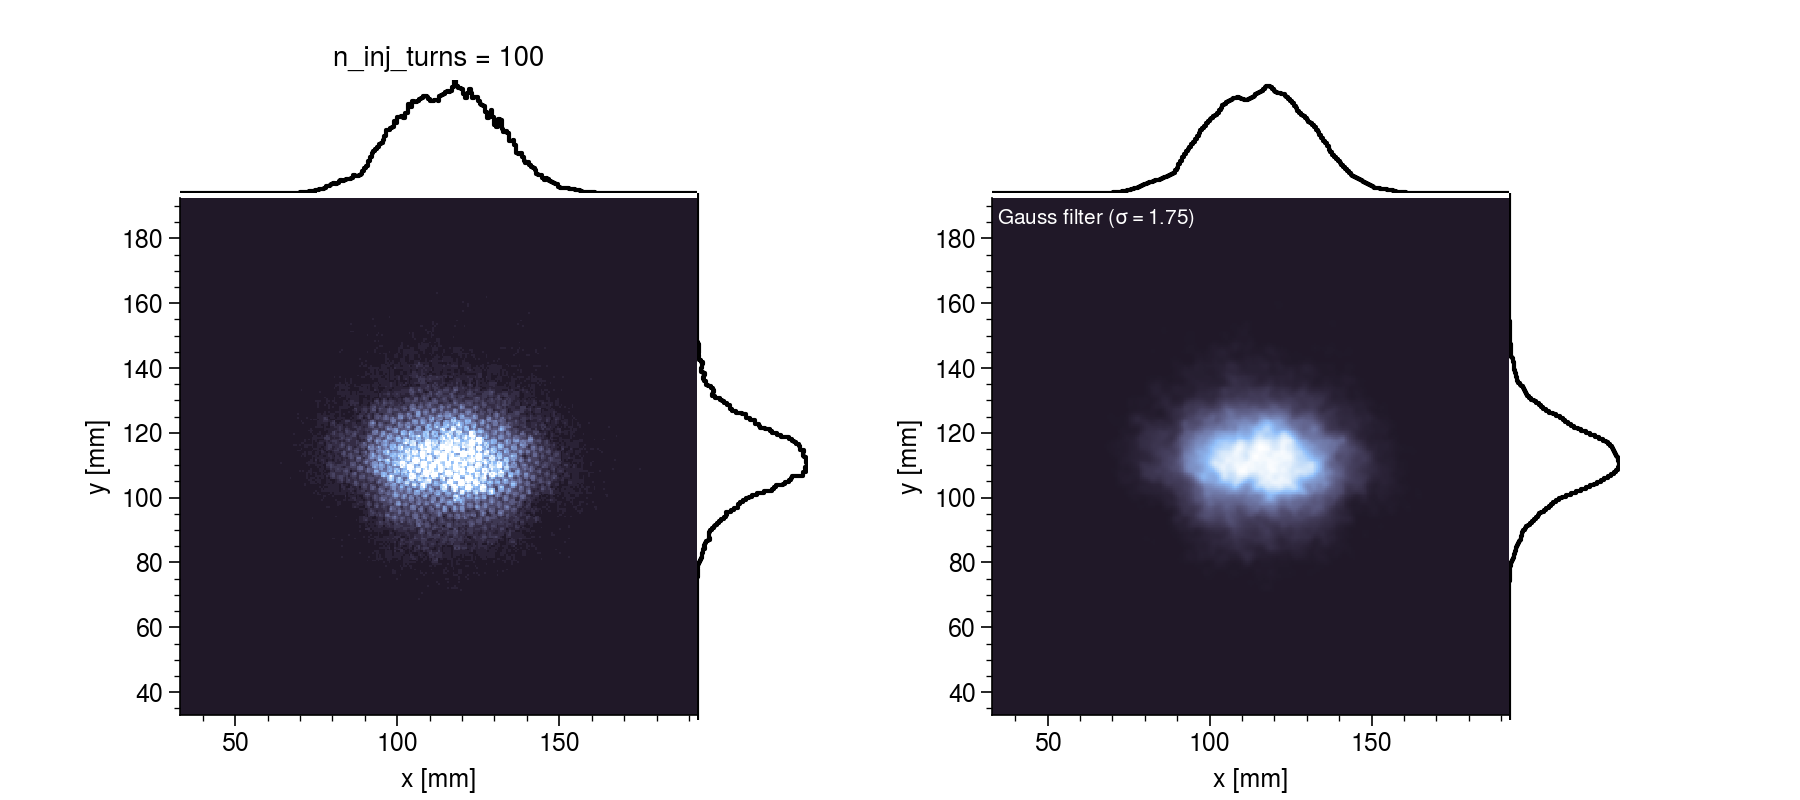

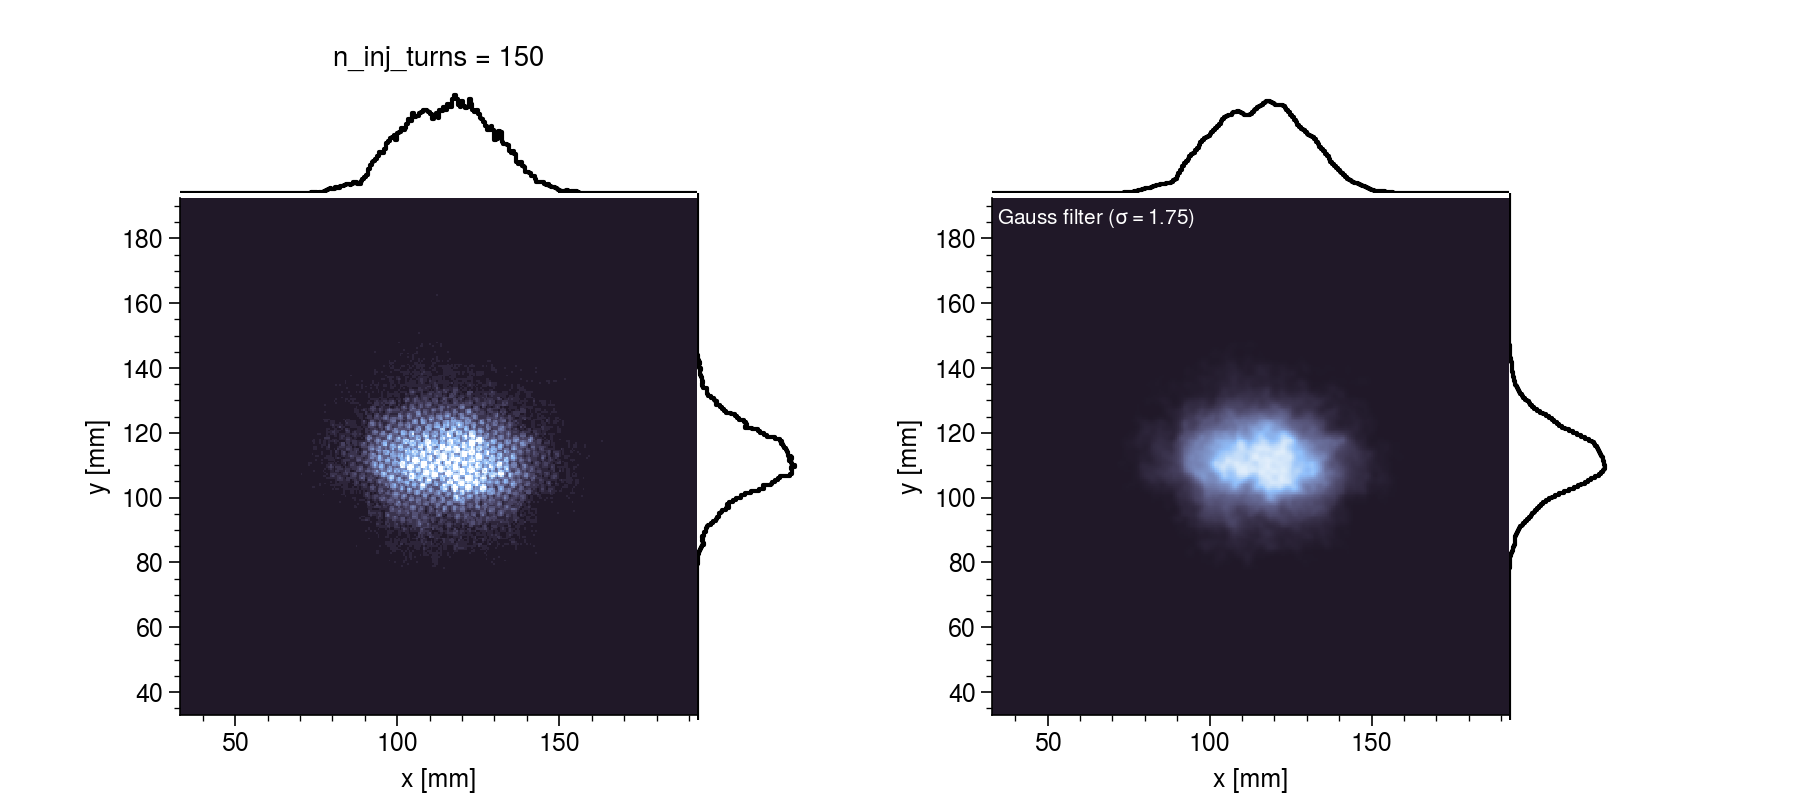

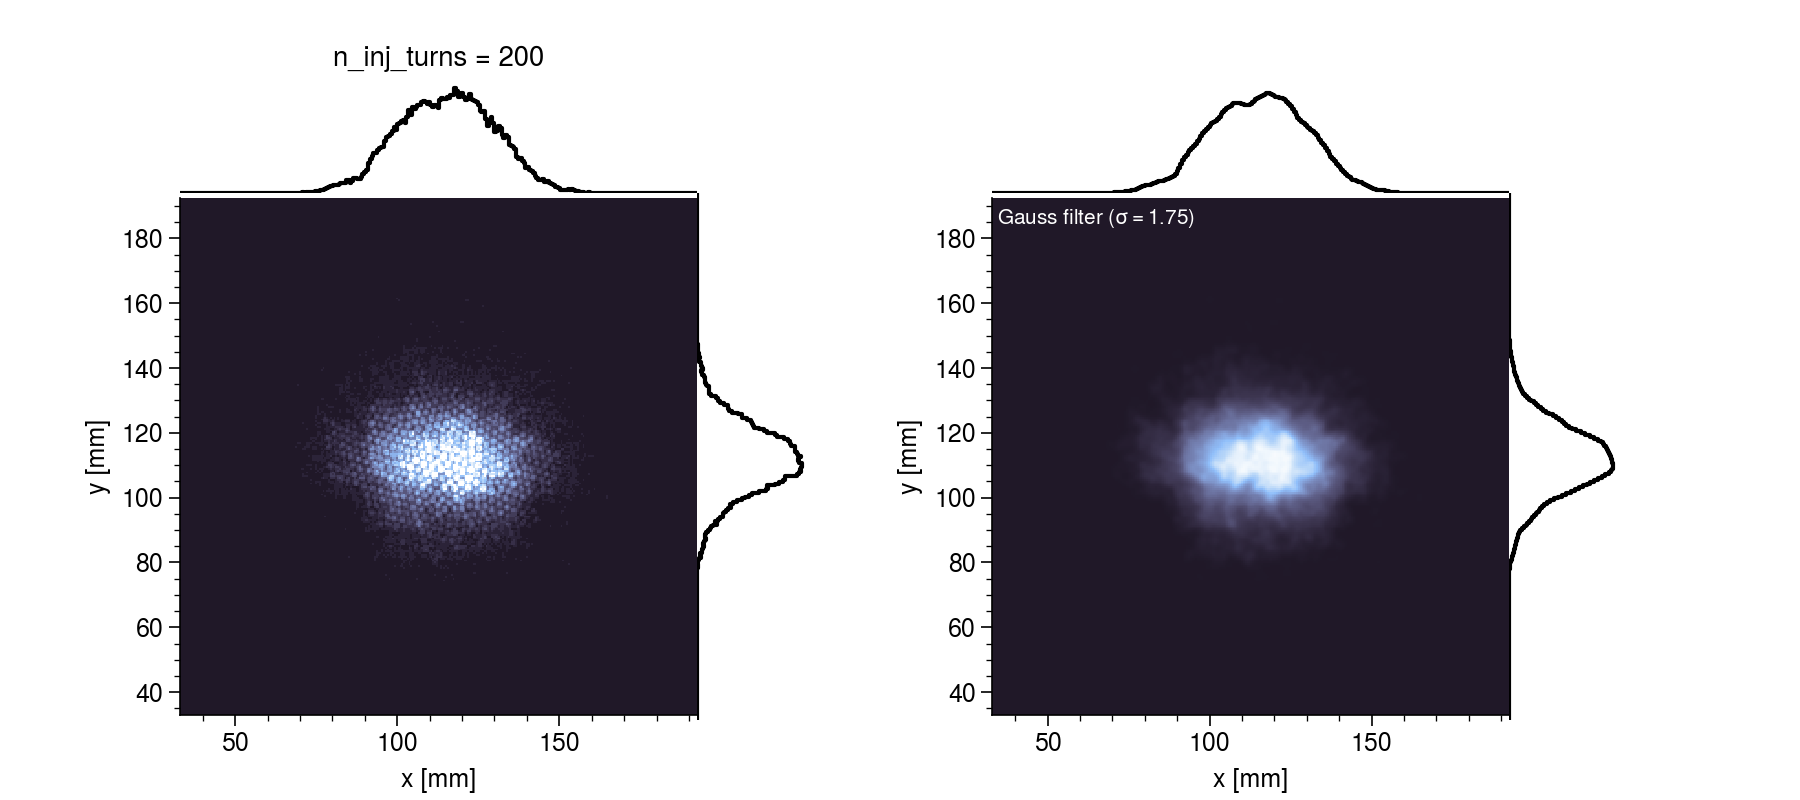

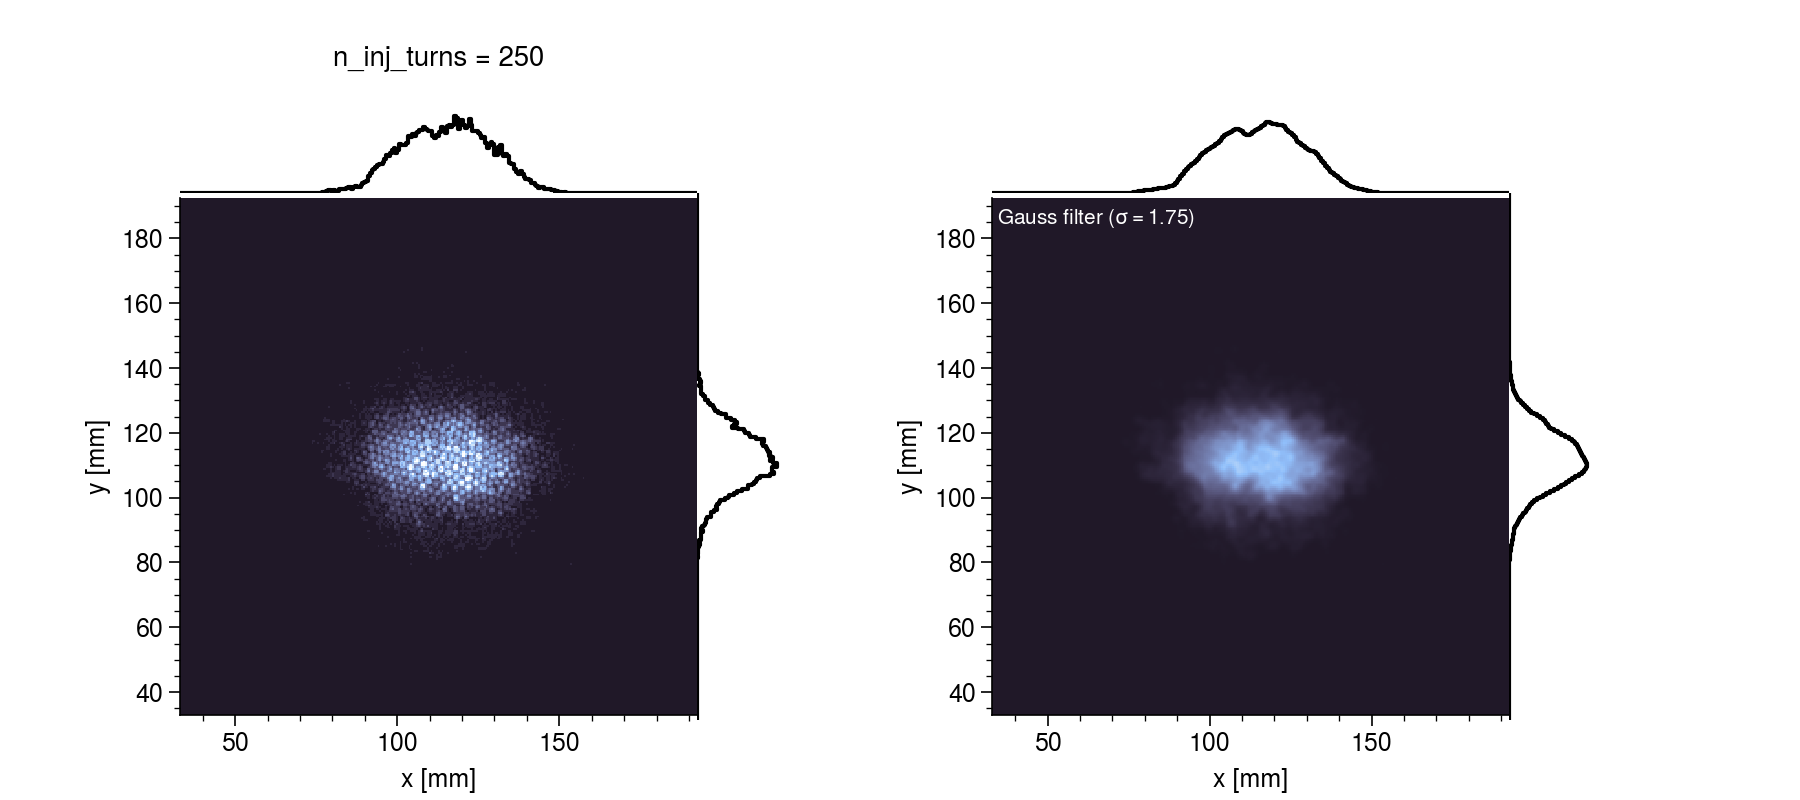

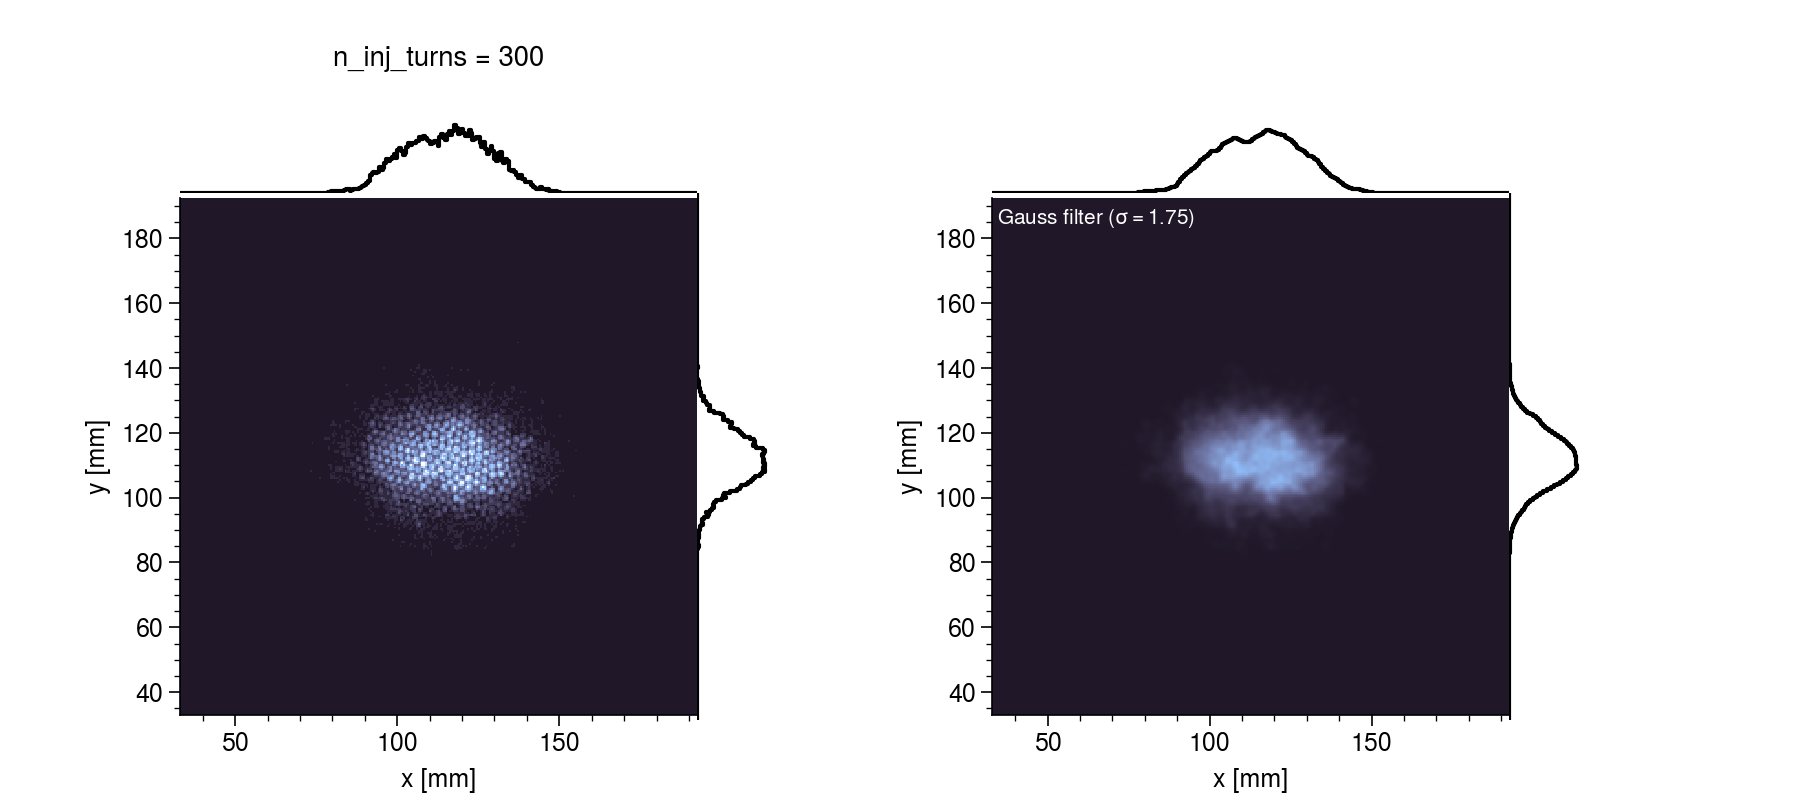

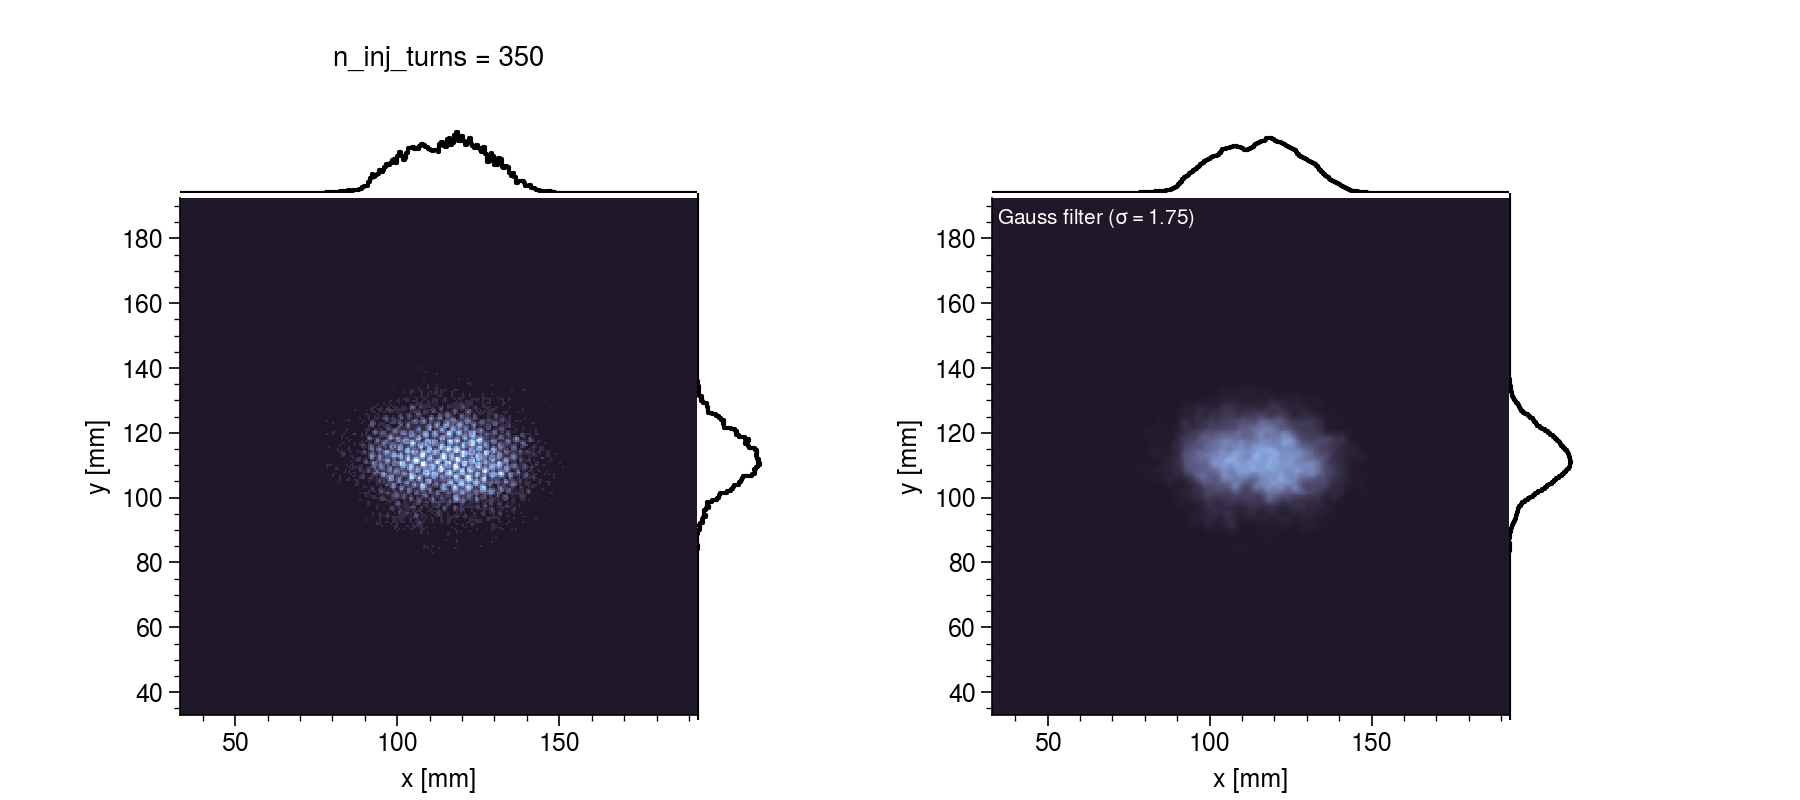

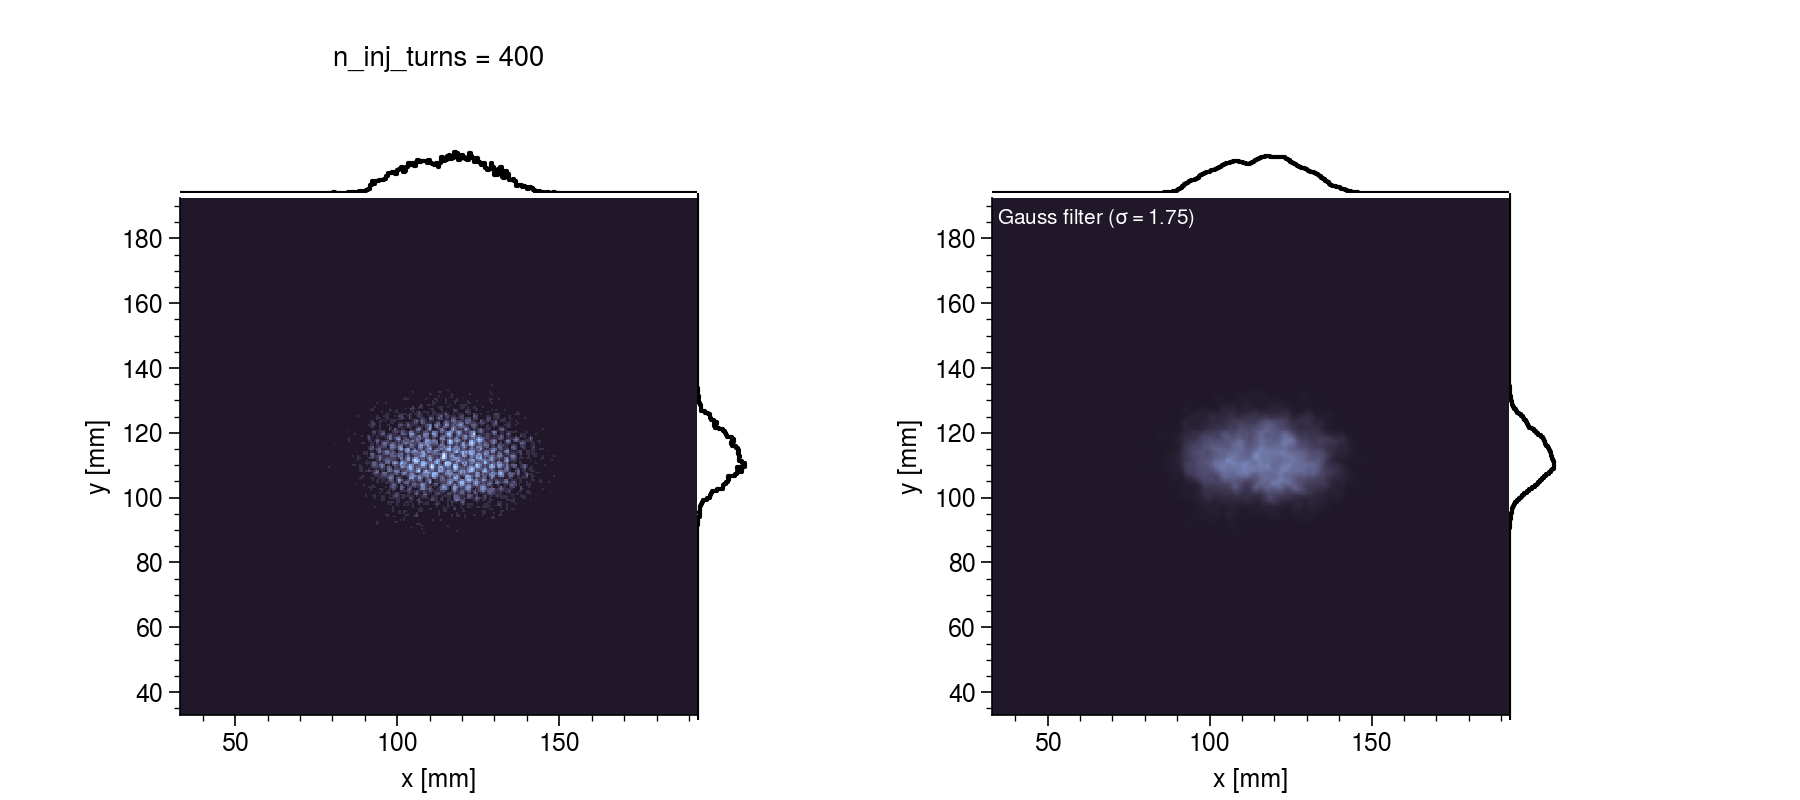

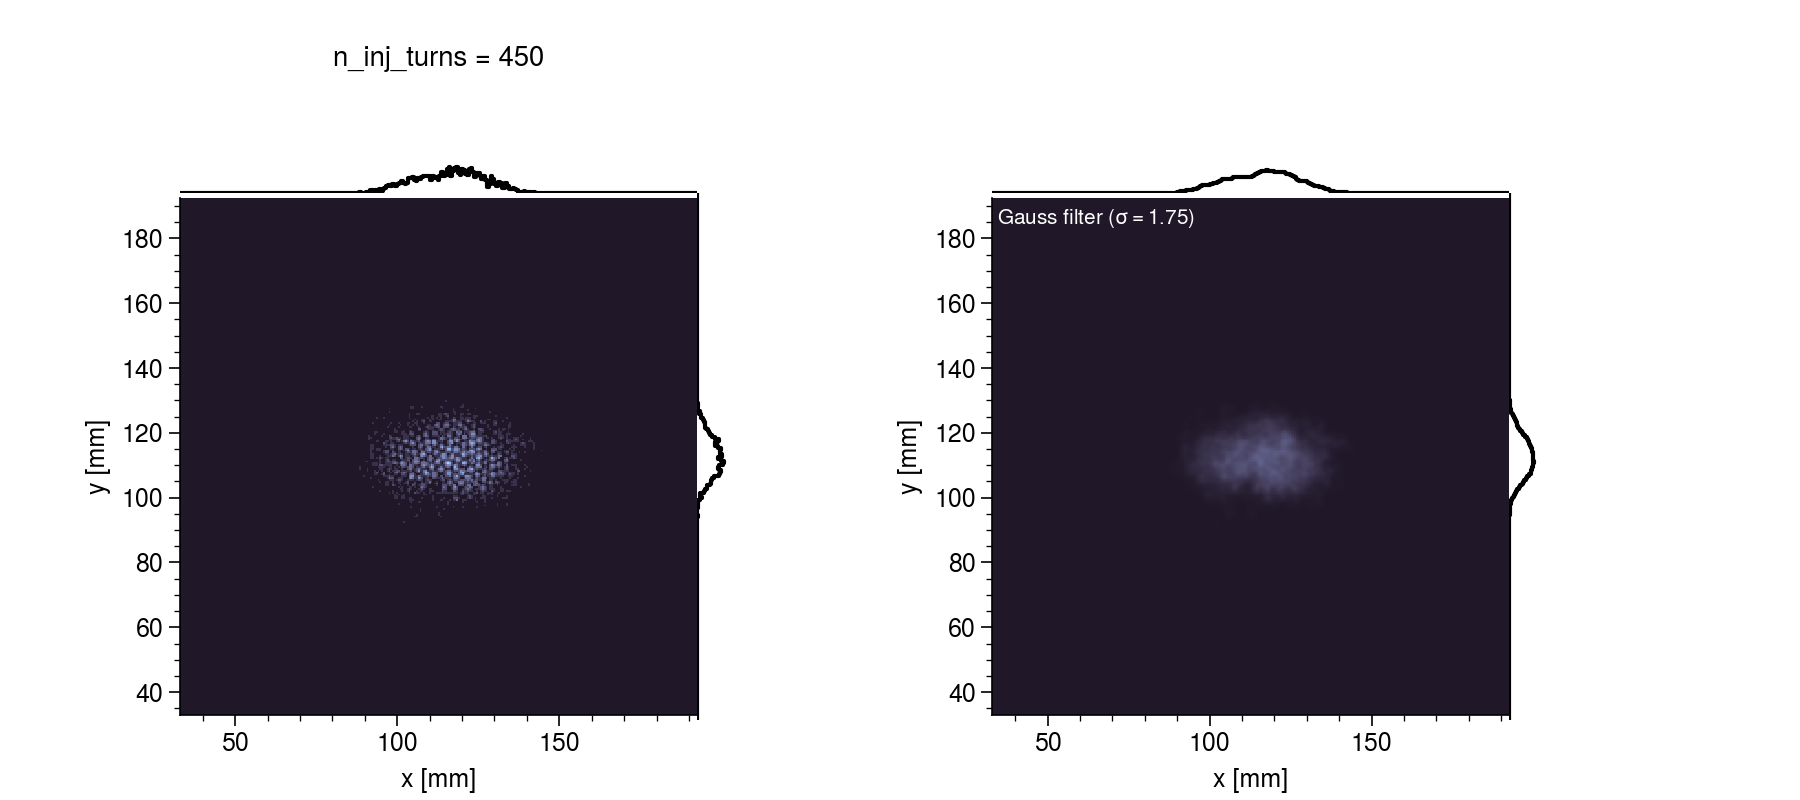

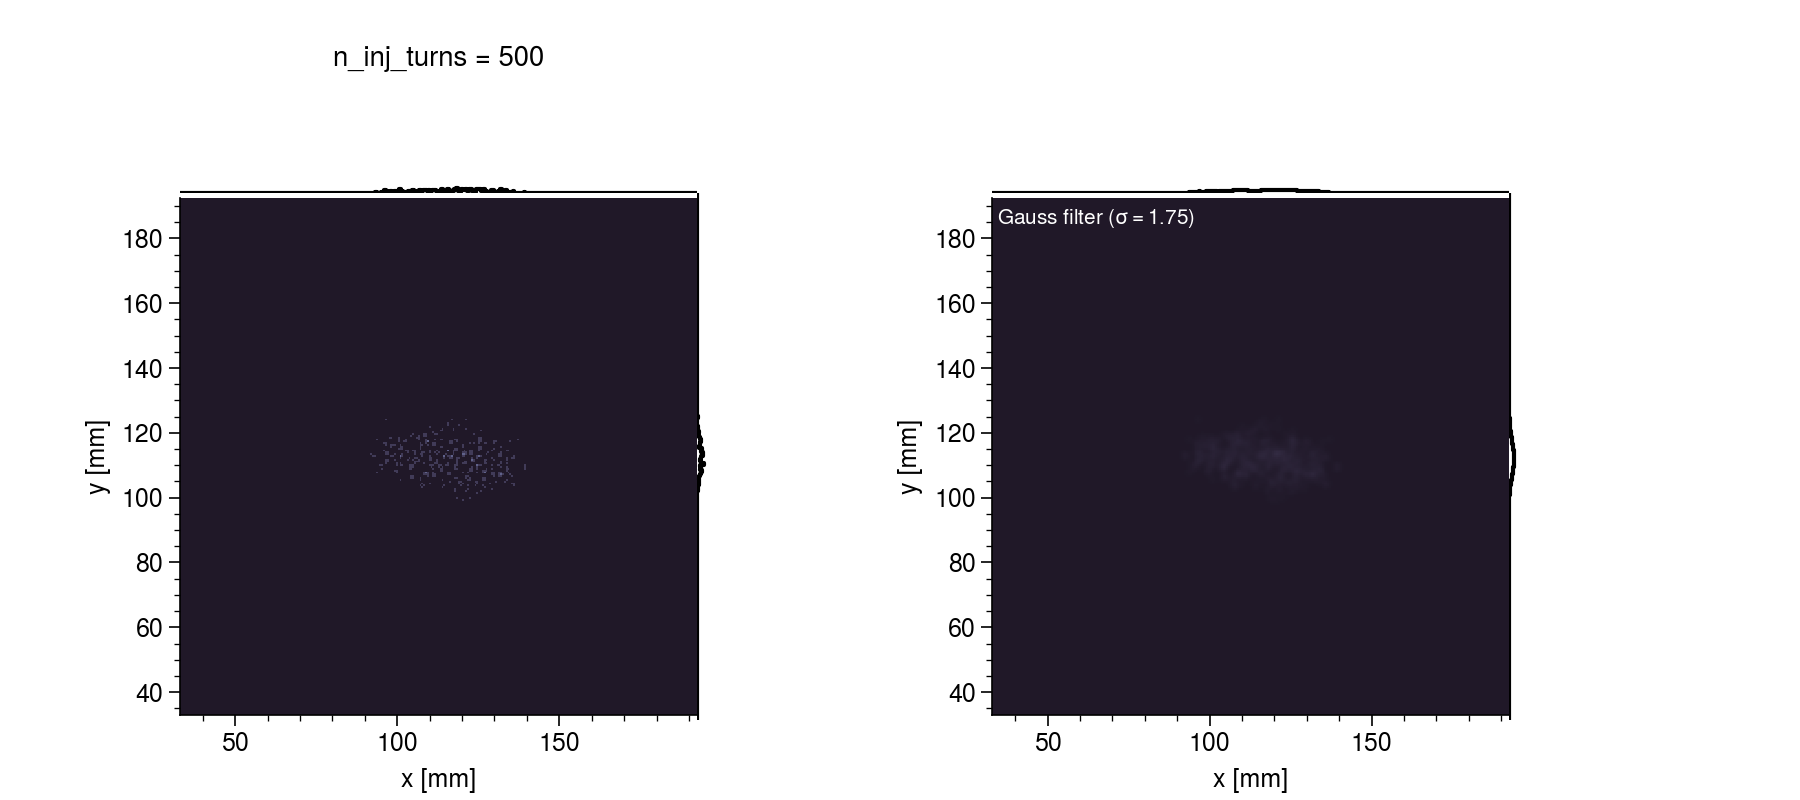

In [12]:
for image, n_turns in zip(images, n_turns_list):
    fig = plt.figure(figsize=(9, 4))
    h = 1.5
    gridspec = fig.add_gridspec(2, 5, width_ratios=(7, h, 2.5, 7, h), height_ratios=(h, 7),
                                left=0.1, right=0.9, bottom=0.1, top=0.9,
                                wspace=0, hspace=0)
    ax1, ax1_marg_x, ax1_marg_y = add_joint_grid(fig, gridspec, 1, 0)
    ax2, ax2_marg_x, ax2_marg_y = add_joint_grid(fig, gridspec, 1, 3)

    joint_kws = dict(cmap='dusk_r')
    marginal_kws = dict(color='black')
    
    X, Y, Z = image.X, image.Y, image.Z
    Zf = image.filter(sigma)
    cmap = 'dusk_r'
    ax1.pcolormesh(X, Y, Z, shading='auto', vmax=max_hist2d_height, **joint_kws)
    ax2.pcolormesh(X, Y, Zf, shading='auto', vmax=max_hist2d_height_filtered, **joint_kws)
    
    ax1_marg_x.step(image.xx, np.sum(Z, axis=0), **marginal_kws)
    ax1_marg_y.step(np.sum(Z, axis=1), image.yy, **marginal_kws)
    ax2_marg_x.step(image.xx, np.sum(Zf, axis=0), **marginal_kws)
    ax2_marg_y.step(np.sum(Zf, axis=1), image.yy, **marginal_kws)
    
    # Zoom in/out
    new_width = image.width / zoom
    delta_x = 0.5 * (image.width - new_width)
    xmin, xmax = ax1.get_xlim()
    xlim = (xmin + delta_x, xmax - delta_x)
    for ax in [ax1, ax2]:
        ax.set_xlim(xlim)
        ax.set_ylim(xlim)
    for ax in [ax1_marg_x, ax2_marg_x]:
        ax.set_xlim(xlim)
        ax.set_ylim(0, max_hist_height_x)
    for ax in [ax1_marg_y, ax2_marg_y]:
        ax.set_ylim(xlim)
        ax.set_xlim(0, max_hist_height_y)
    for ax in [ax1, ax2]:
        ax.set_xlabel('x [mm]')
        ax.set_ylabel('y [mm]')
        ax.set_aspect(1)
        
    ax2.annotate(r'Gauss filter ($\sigma = {}$)'.format(sigma), xy=(0.01, 0.95), xycoords='axes fraction', color='white', fontsize='small')
    ax1_marg_x.set_title('n_inj_turns = {}'.format(n_turns))
    plt.savefig('_output/target_image_ninjturns={}.png'.format(n_turns), facecolor='white', dpi=300)
    plt.show()